# QC and DEG analysis

In [1]:
suppressPackageStartupMessages({
    library(Seurat)
    library(SeuratWrappers)
    library(tidyverse)
    library(reticulate)
    library(MAST)
    library(velocyto.R)
    library(monocle3)
    library(ggplot2)
    library(patchwork)
    library(magrittr)
})
options(warn=-1)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


In [2]:
# Load loom file as it has the RNA unspliced+spliced information
ldat <- ReadVelocity(file = "aggr/merged.loom")
so <- as.Seurat(x = ldat) 

In [3]:
so

An object of class Seurat 
41889 features across 8249 samples within 3 assays 
Active assay: spliced (13963 features, 0 variable features)
 2 other assays present: unspliced, ambiguous

In [13]:
# check the content
head(so@meta.data)

orig.ident    nCount_spliced nFeature_spliced
1DAE:AACCATGGTAAGCAATx SeuratProject 42819          3477            
1DAE:AACCCAAAGCTATCTGx SeuratProject 27407          3018            
1DAE:AAAGGATTCTTGTGCCx SeuratProject 22334          2928            
1DAE:AAACGAAAGCACTCCGx SeuratProject   779           269            
1DAE:AACAAAGAGAATAGTCx SeuratProject 14780          1958            
1DAE:AACAAGACAGCTTCGGx SeuratProject 22777          2480            
                       nCount_unspliced nFeature_unspliced nCount_ambiguous
1DAE:AACCATGGTAAGCAATx 3926             714                1101            
1DAE:AACCCAAAGCTATCTGx 2207             517                 657            
1DAE:AAAGGATTCTTGTGCCx 1371             397                 567            
1DAE:AAACGAAAGCACTCCGx   14               9                   3            
1DAE:AACAAAGAGAATAGTCx 1265             277                 356            
1DAE:AACAAGACAGCTTCGGx 1275             352                 451            
                       nFeature_ambiguous
1DAE:AACCATGGTAAGCAATx 318               
1DAE:AACCCAAAGCTATCTGx 240               
1DAE:AAAGGATTCTTGTGCCx 211               
1DAE:AAACGAAAGCACTCCGx   3               
1DAE:AACAAAGAGAATAGTCx 148               
1DAE:AACAAGACAGCTTCGGx 171

In [14]:
# Get the sample information from the barcodes
barcode.gb <- names(Idents(so))
SampleID.gb <- substring(barcode.gb,1,4)
names(SampleID.gb) <- barcode.gb
head(SampleID.gb)

1DAE:AACCATGGTAAGCAATx 1DAE:AACCCAAAGCTATCTGx 1DAE:AAAGGATTCTTGTGCCx 
                "1DAE"                 "1DAE"                 "1DAE" 
1DAE:AAACGAAAGCACTCCGx 1DAE:AACAAAGAGAATAGTCx 1DAE:AACAAGACAGCTTCGGx 
                "1DAE"                 "1DAE"                 "1DAE"

In [15]:
# Assign to new column "sample" in the metadata
so@meta.data$sample <- SampleID.gb
ids <- factor(so@meta.data$sample, levels = c("1DAE", "3DAE"))
names(ids) <- rownames(so@meta.data)
ids[1:3]

1DAE:AACCATGGTAAGCAATx 1DAE:AACCCAAAGCTATCTGx 1DAE:AAAGGATTCTTGTGCCx 
                  1DAE                   1DAE                   1DAE 
Levels: 1DAE 3DAE

In [16]:
# How many cells are in each sample
so@meta.data$sample <- ids
Idents(object = so) <- so$sample
summary(Idents(object= so))

1DAE 3DAE 
4962 3287

# Quality control

In [17]:
# Calculate the mitochondrial genes
so[["percent.mt"]] <- PercentageFeatureSet(so, pattern = "^mt:")

# Calculate the ribosomal genes
so[["percent.rb"]] <- PercentageFeatureSet(so, pattern = "^Rp")

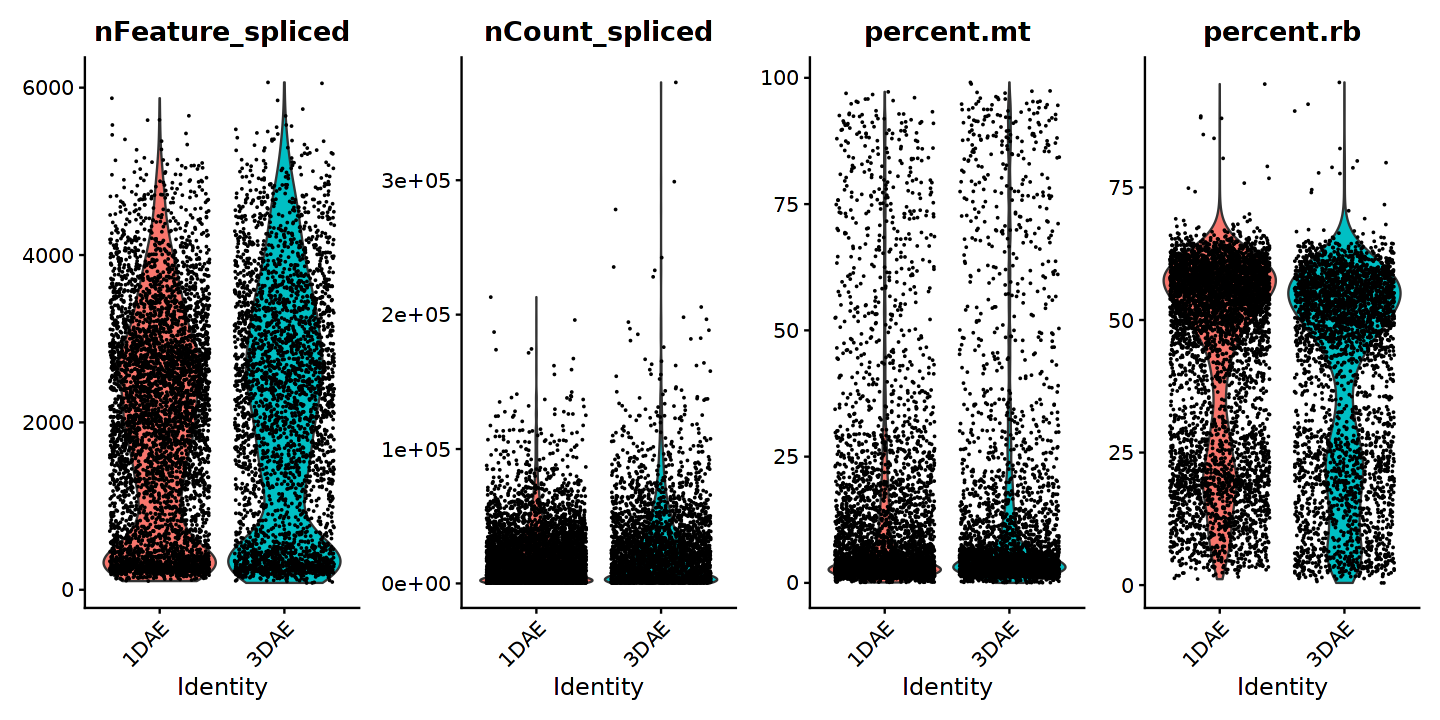

In [18]:
options(repr.plot.width = 12, repr.plot.height = 6)
VlnPlot(so, features = c("nFeature_spliced", "nCount_spliced", "percent.mt", "percent.rb"), ncol = 4, pt.size = 0.01)

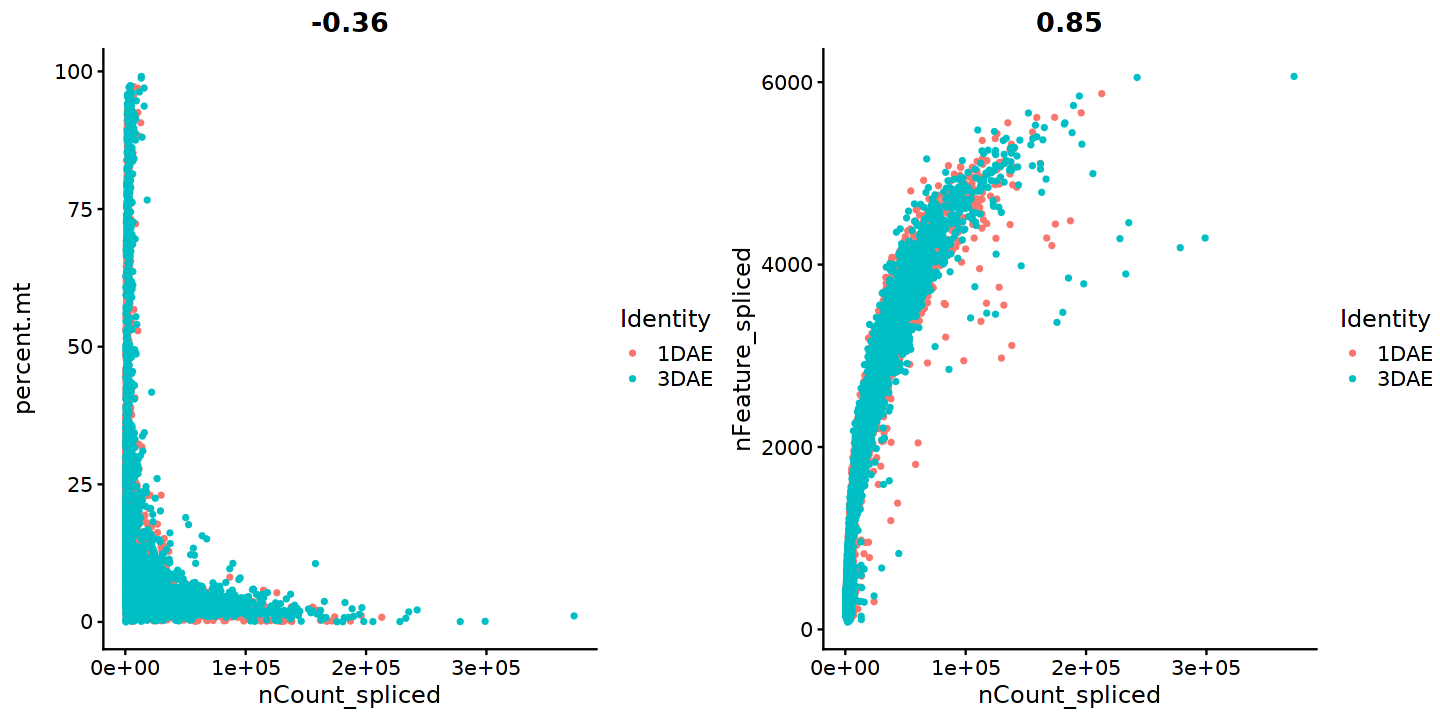

In [20]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.

options(repr.plot.width = 12, repr.plot.height = 6)
plot1 <- FeatureScatter(so, feature1 = "nCount_spliced", feature2 = "percent.mt")
plot2 <- FeatureScatter(so, feature1 = "nCount_spliced", feature2 = "nFeature_spliced")
CombinePlots(plots = list(plot1, plot2))

In [22]:
# Filter out features and mitochondrial content based on visual check
so <- subset(so, subset = nFeature_spliced > 1000 & nFeature_spliced < 5000 & percent.mt < 5)

In [23]:
# SCTransform normalization enables recovering sharper biological distinction compared to log-normalization
so <- SCTransform(so, assay = "spliced", vars.to.regress = c("percent.mt", "nCount_spliced"), verbose = FALSE)
so <- RunPCA(so)

PC_ 1 
Positive:  Tsp29Fb, CG13321, Ssk, CG15347, CG44014, CG15422, Tsp2A, CG13315, CG34288, Fst 
	   lectin-37Db, CG13704, CG5011, Pebp1, GstE3, CG1246, Argk, CG12974, CG15152, CG43349 
	   CG12780, CG12825, CG15211, CG10912, CG32633, Cyp12a4, CG15210, CG32687, CG13086, CG8907 
Negative:  RpL41, RpL27A, RpLP1, RpS7, sta, Df31, bun, RpS26, eEF1alpha1, RpL27 
	   RpL37a, Pen, RpS29, Cpr51A, Cyp1, HmgD, cib, Myc, Prx2540-1, Dtg 
	   CG17778, unc-104, Tet, Tsp42Ee, hdc, awd, dUTPase, RpS19a, aqz, CNBP 
PC_ 2 
Positive:  CG17778, unc-104, Thor, Prx2540-1, bun, Prx2540-2, Sirup, CG12896, stl, RpL27A 
	   CG34198, CG5254, CG44085, CG11825, ATP8B, CG8839, CG32264, CG17145, hebe, CG7470 
	   CG15098, Lsd-2, CG30090, Cyp6a9, GstT4, DOR, CG6770, CG13868, RpS29, pirk 
Negative:  Tsp42Ee, Cyt-c-p, CG7142, Pen, Fkbp39, hoip, alphaTub84B, PCNA, dUTPase, CG11267 
	   CG13704, HmgD, CG12926, Ldh, CG45060, h, CG1943, CG32368, awd, smt3 
	   Nazo, Prip, NHP2, Ran, eEF1delta, Ant2, Jafrac1, CG9568, Act42

In [24]:
# Number of Principal Components to be used in the further steps
ndim <- 20

so <- FindNeighbors(so, dims = 1:ndim) %>%
      FindClusters(resolution = c(0.3, 0.5, 0.6, 0.8, 1, 1.6), force.recalc= FALSE)
head(Idents(so), 5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4276
Number of edges: 141138

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8780
Number of communities: 10
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4276
Number of edges: 141138

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8344
Number of communities: 12
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4276
Number of edges: 141138

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8195
Number of communities: 15
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4276
Number of edges: 141138

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7963
Number of communities: 15
Elapsed time: 0 seconds
Modularity Optim

1DAE:AACCATGGTAAGCAATx 1DAE:AACCCAAAGCTATCTGx 1DAE:AAAGGATTCTTGTGCCx 
                     8                      0                      0 
1DAE:AACAAAGAGAATAGTCx 1DAE:AACAAGACAGCTTCGGx 
                     7                     11 
Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18

In [25]:
so <- RunUMAP(so, dims = 1:ndim, verbose = FALSE) %>%
      RunVelocity(deltaT = 1, kCells = 25, fit.quantile = 0.02, verbose = FALSE)

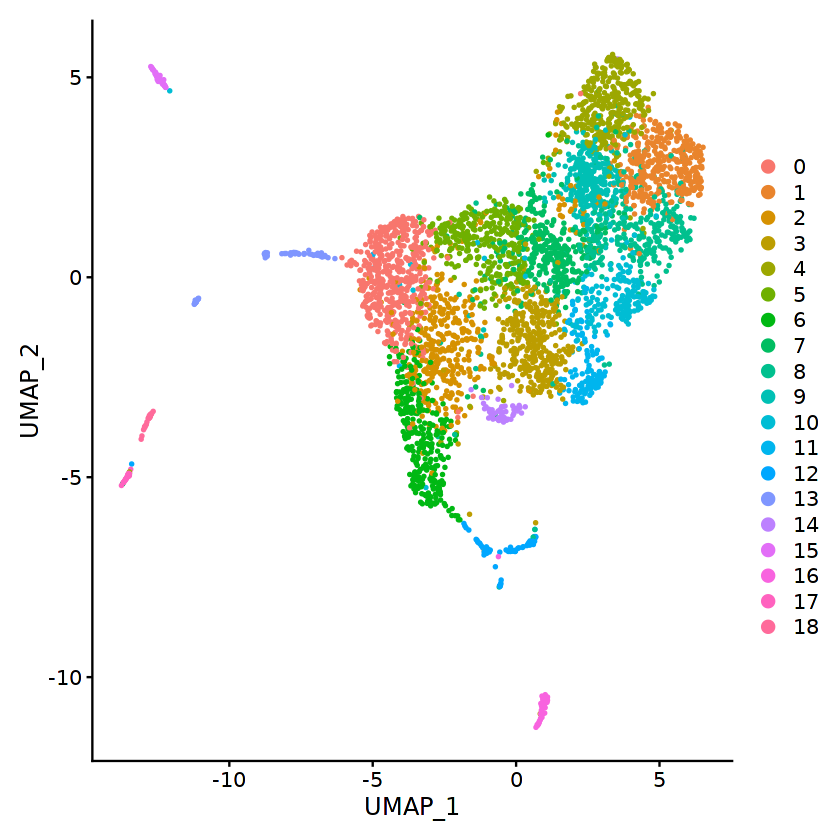

In [26]:
options(repr.plot.width = 7, repr.plot.height = 7)
DimPlot(so, reduction = "umap", pt.size = 0.5)

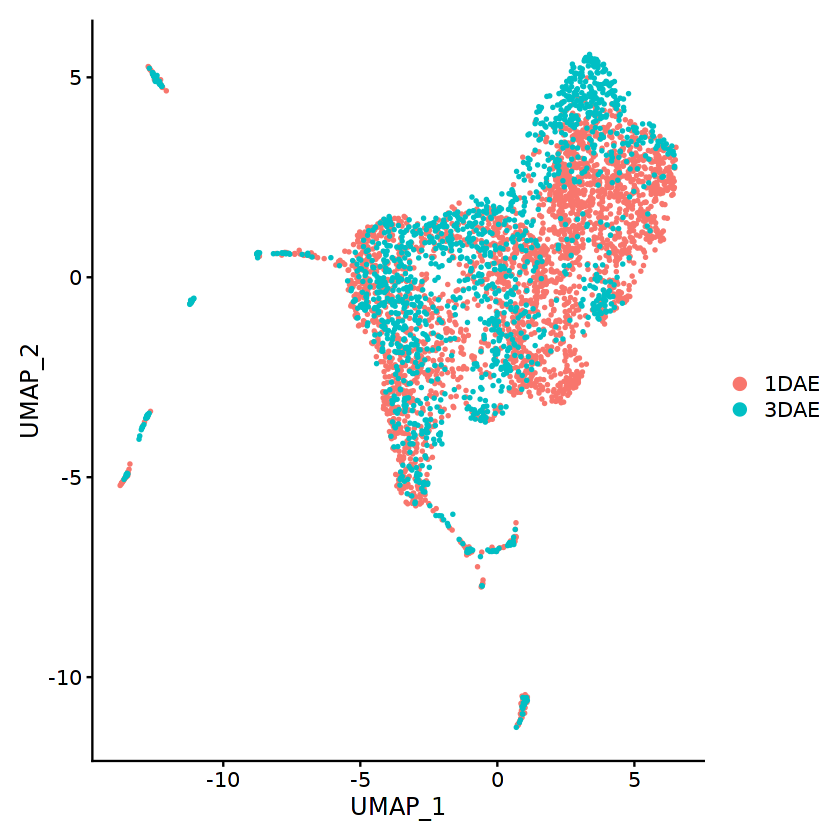

In [28]:
Idents(object = so) <- so$sample
DimPlot(object = so , reduction = "umap", pt.size = .5)

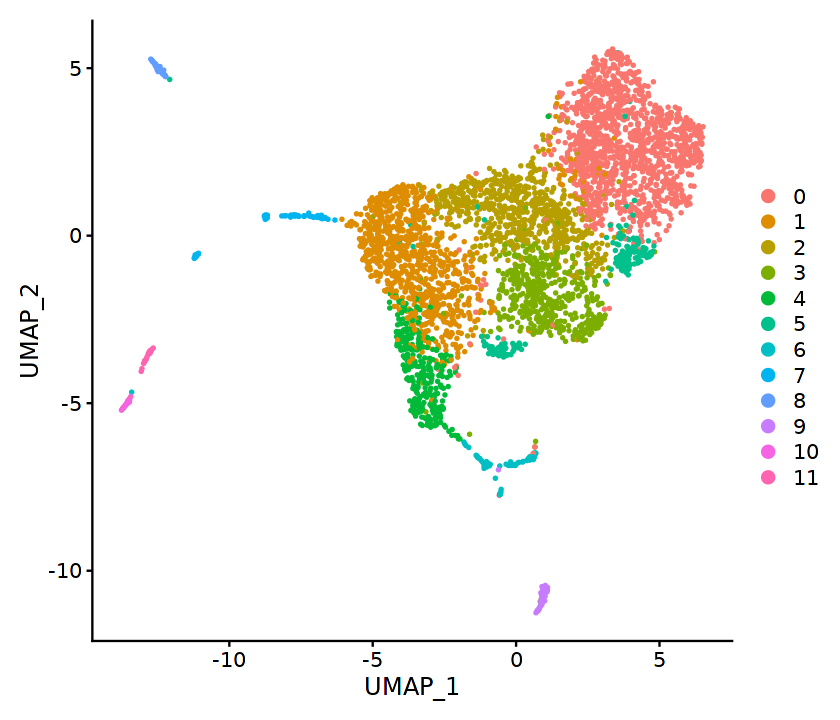

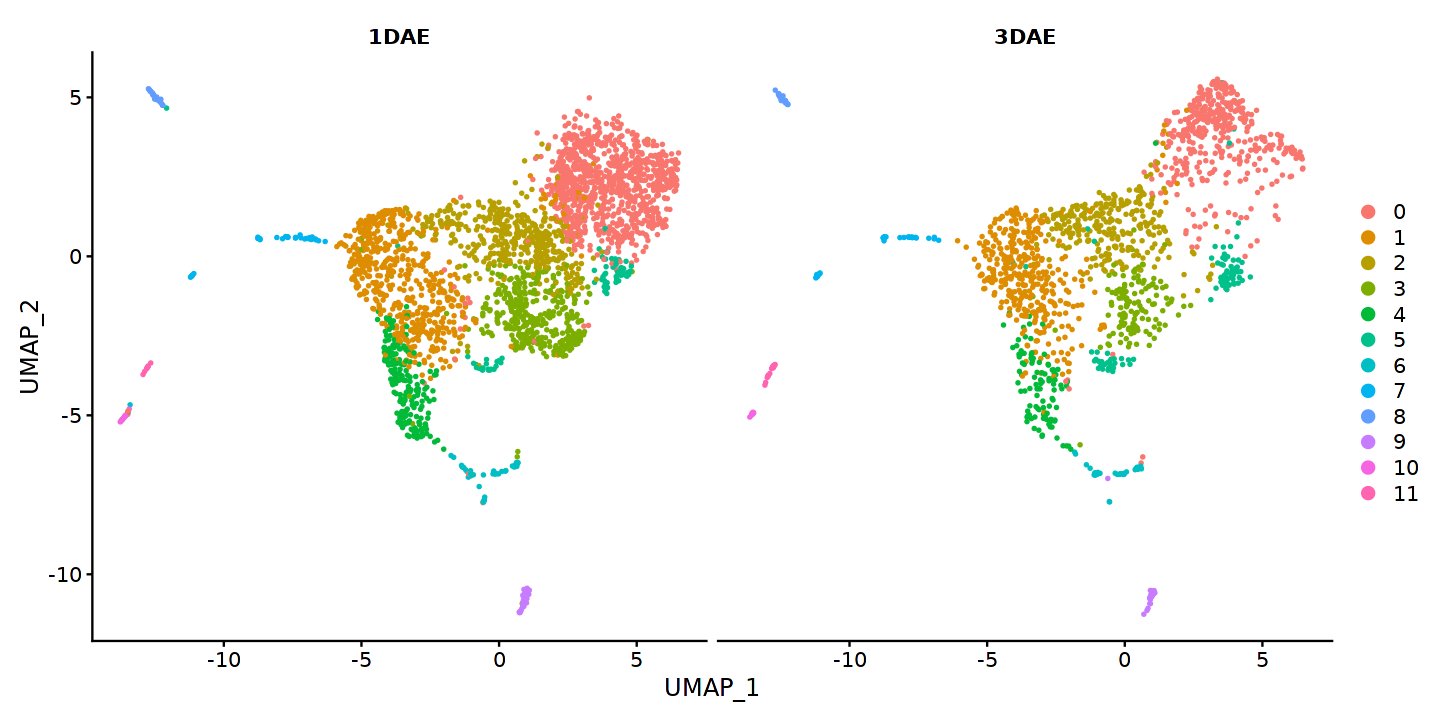

In [30]:
Idents(object = so) <- so$SCT_snn_res.0.5

options(repr.plot.width = 7, repr.plot.height = 6)
DimPlot(object = so, reduction = "umap", pt.size = .5)
ggsave("results/seurat_QC_plots/UMAP_DimPlot_clusters_res.05.pdf", width = 7, height = 6)


options(repr.plot.width = 12, repr.plot.height = 6)
DimPlot(object = so, reduction = "umap", split.by = "sample", pt.size = .5)
ggsave("results/seurat_QC_plots/UMAP_DimPlot_clusters_res.05_sample.pdf", width = 12, height = 6)

In [31]:
so.markers <- FindAllMarkers(so, only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.7)
top3 <- so.markers %>% group_by(cluster) %>% top_n(n = 3, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11



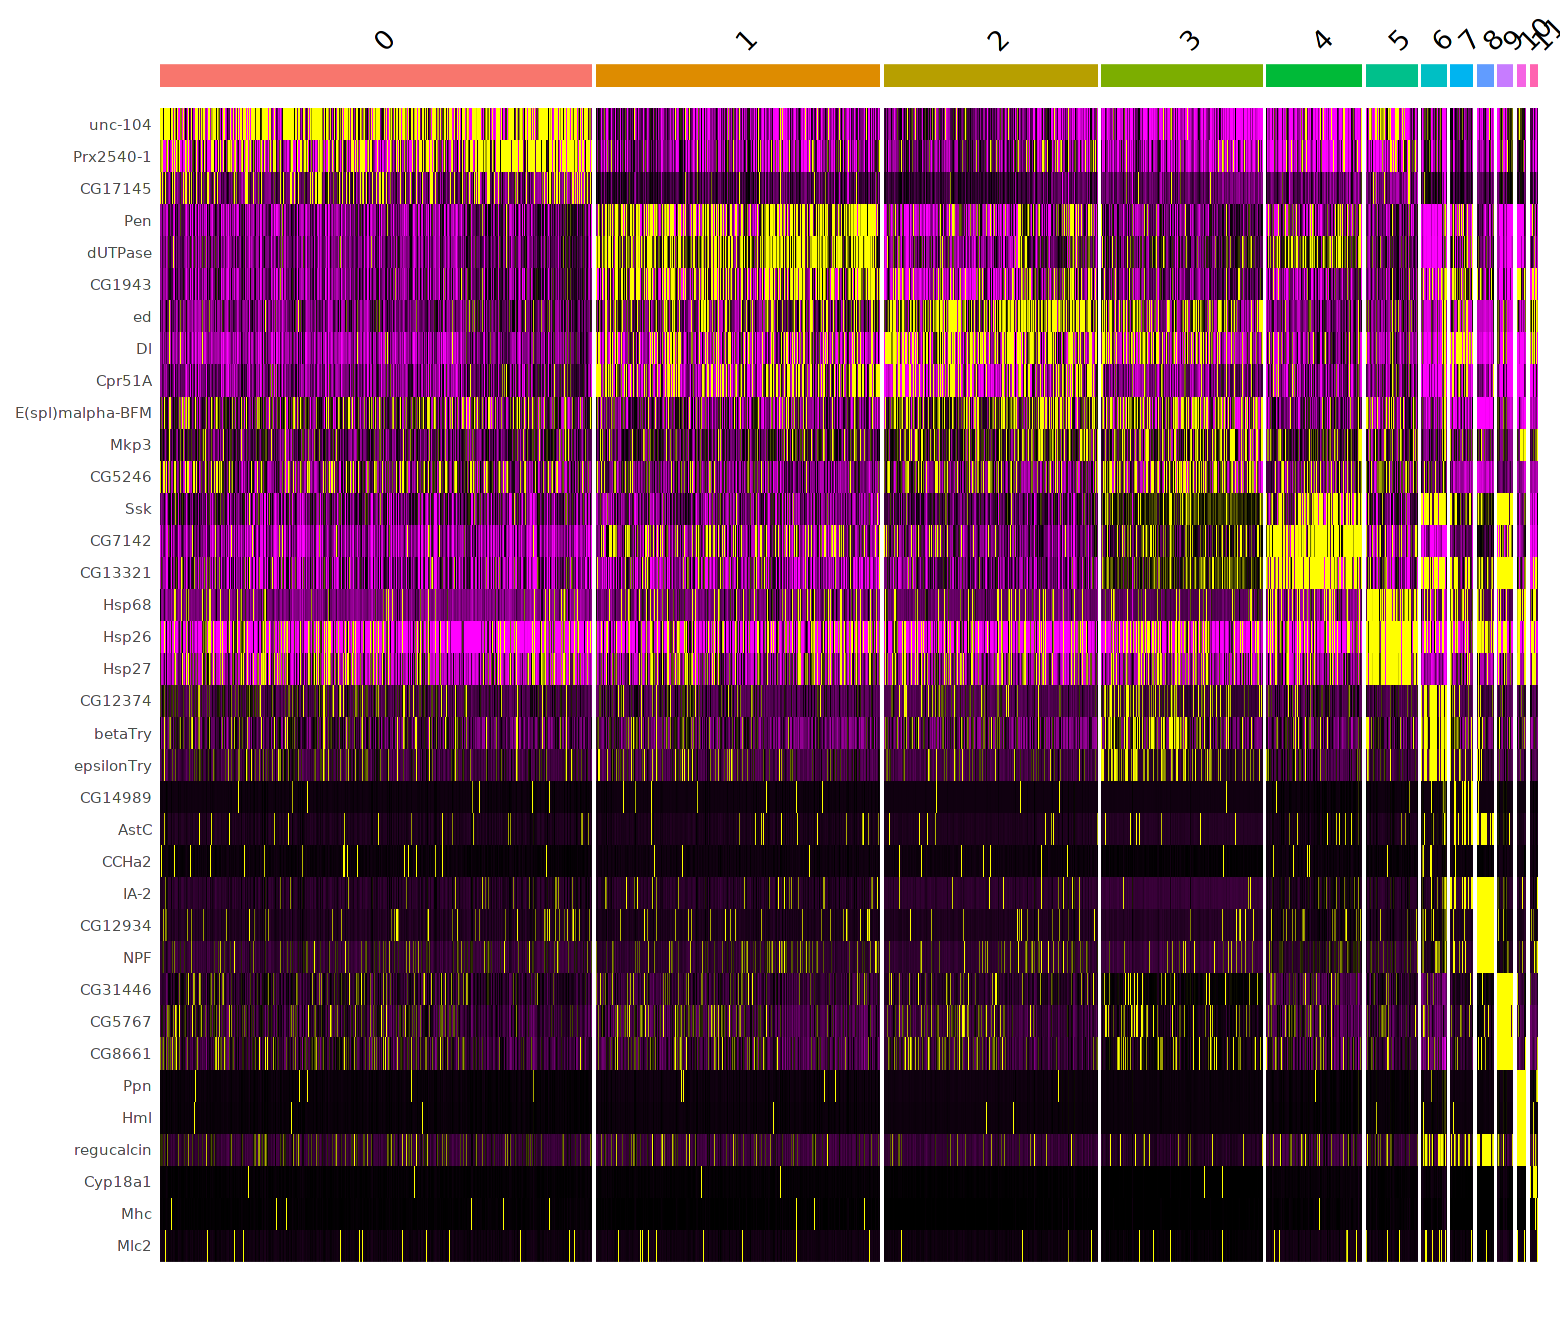

In [33]:
options(repr.plot.width = 13, repr.plot.height = 11)
DoHeatmap(so, features = top3$gene) + NoLegend()

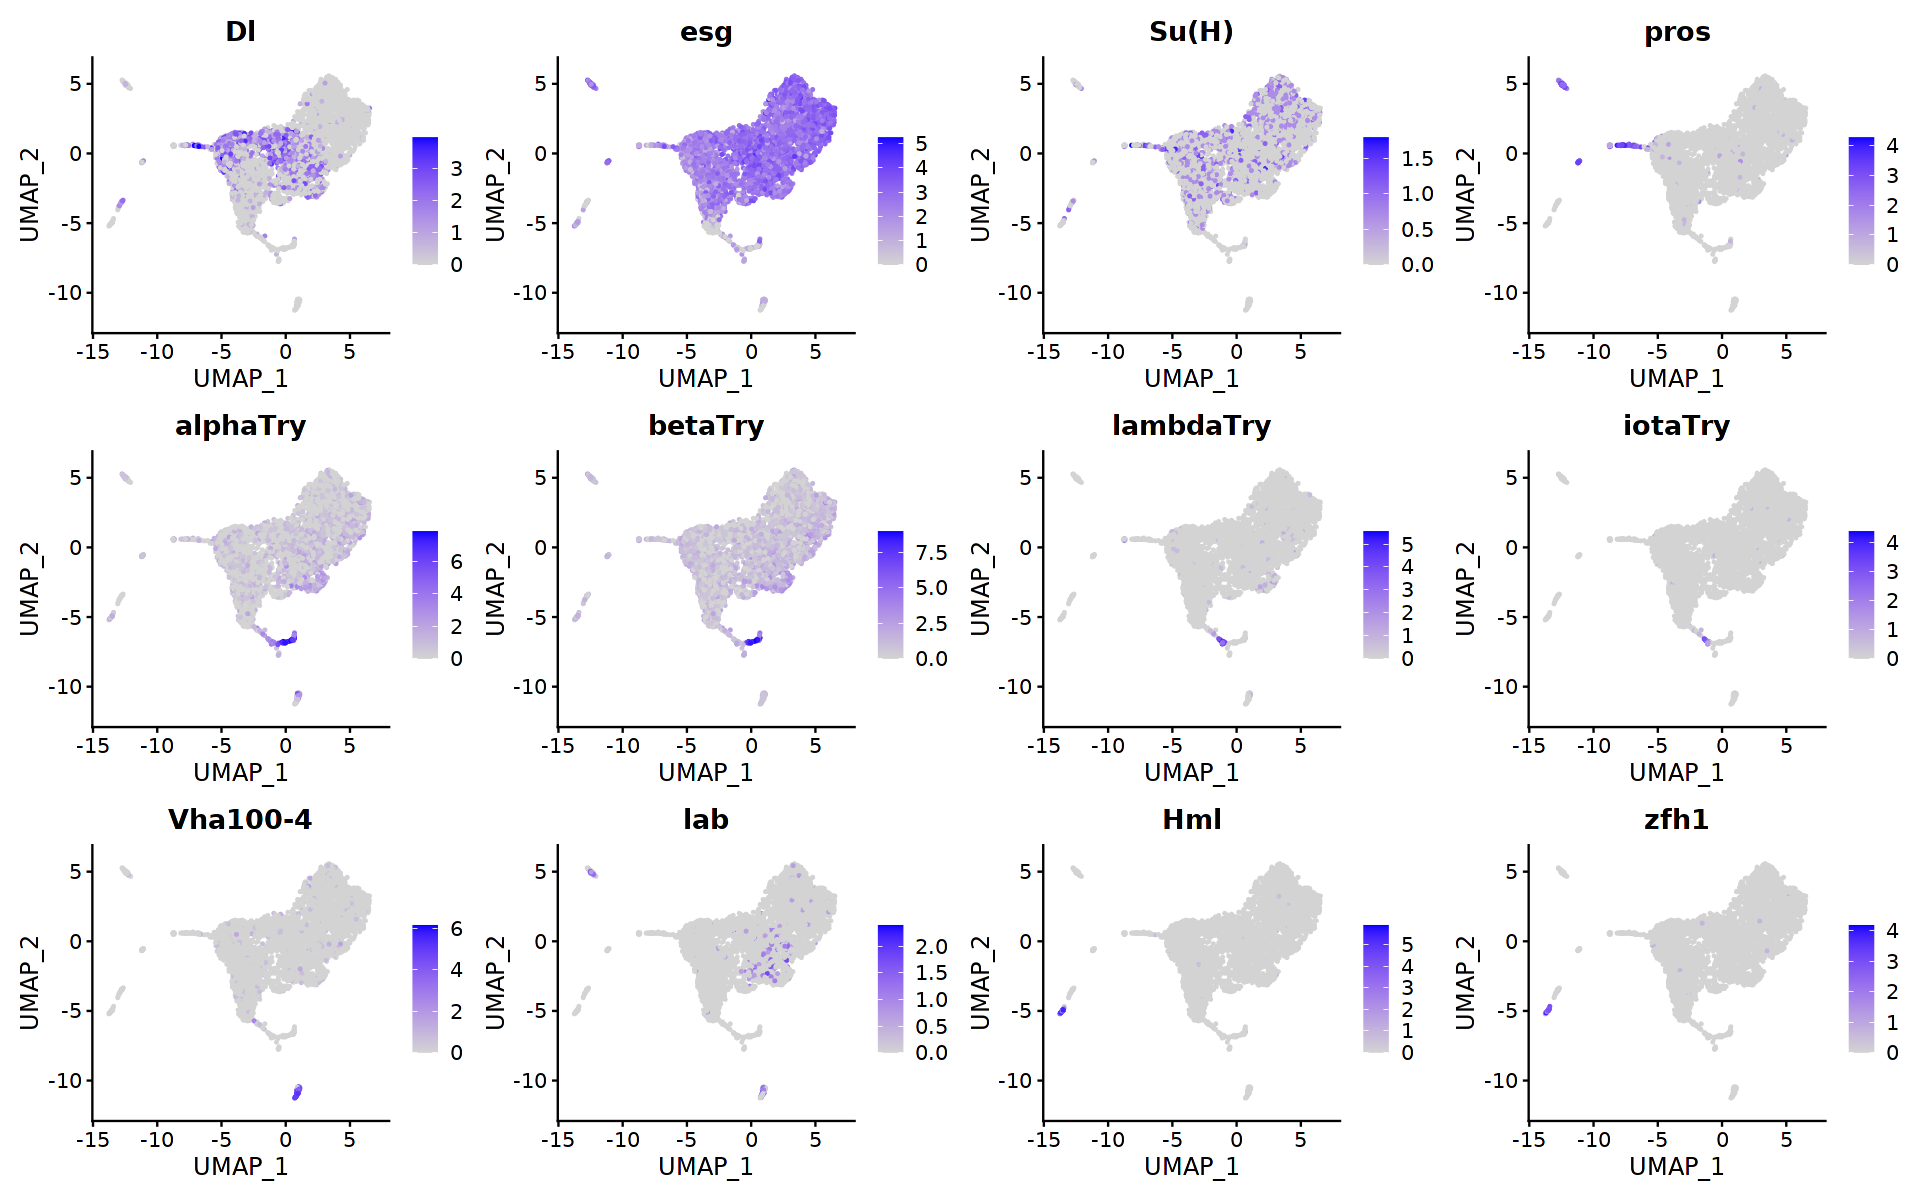

In [35]:
# Visualizae canonical marker genes on the scTransform embedding
markergenes <- c("Dl", "esg", "Su(H)", "pros", "alphaTry", "betaTry", "lambdaTry", "iotaTry", "Vha100-4", "lab", "Hml", "zfh1")

options(repr.plot.width = 16, repr.plot.height = 10)
FeaturePlot(object = so,
            features = markergenes,
            cols = c("lightgrey", "blue"), 
            reduction= "umap")
ggsave("results/seurat_QC_plots/UMAP_marker_genes.pdf", width = 16, height = 10)

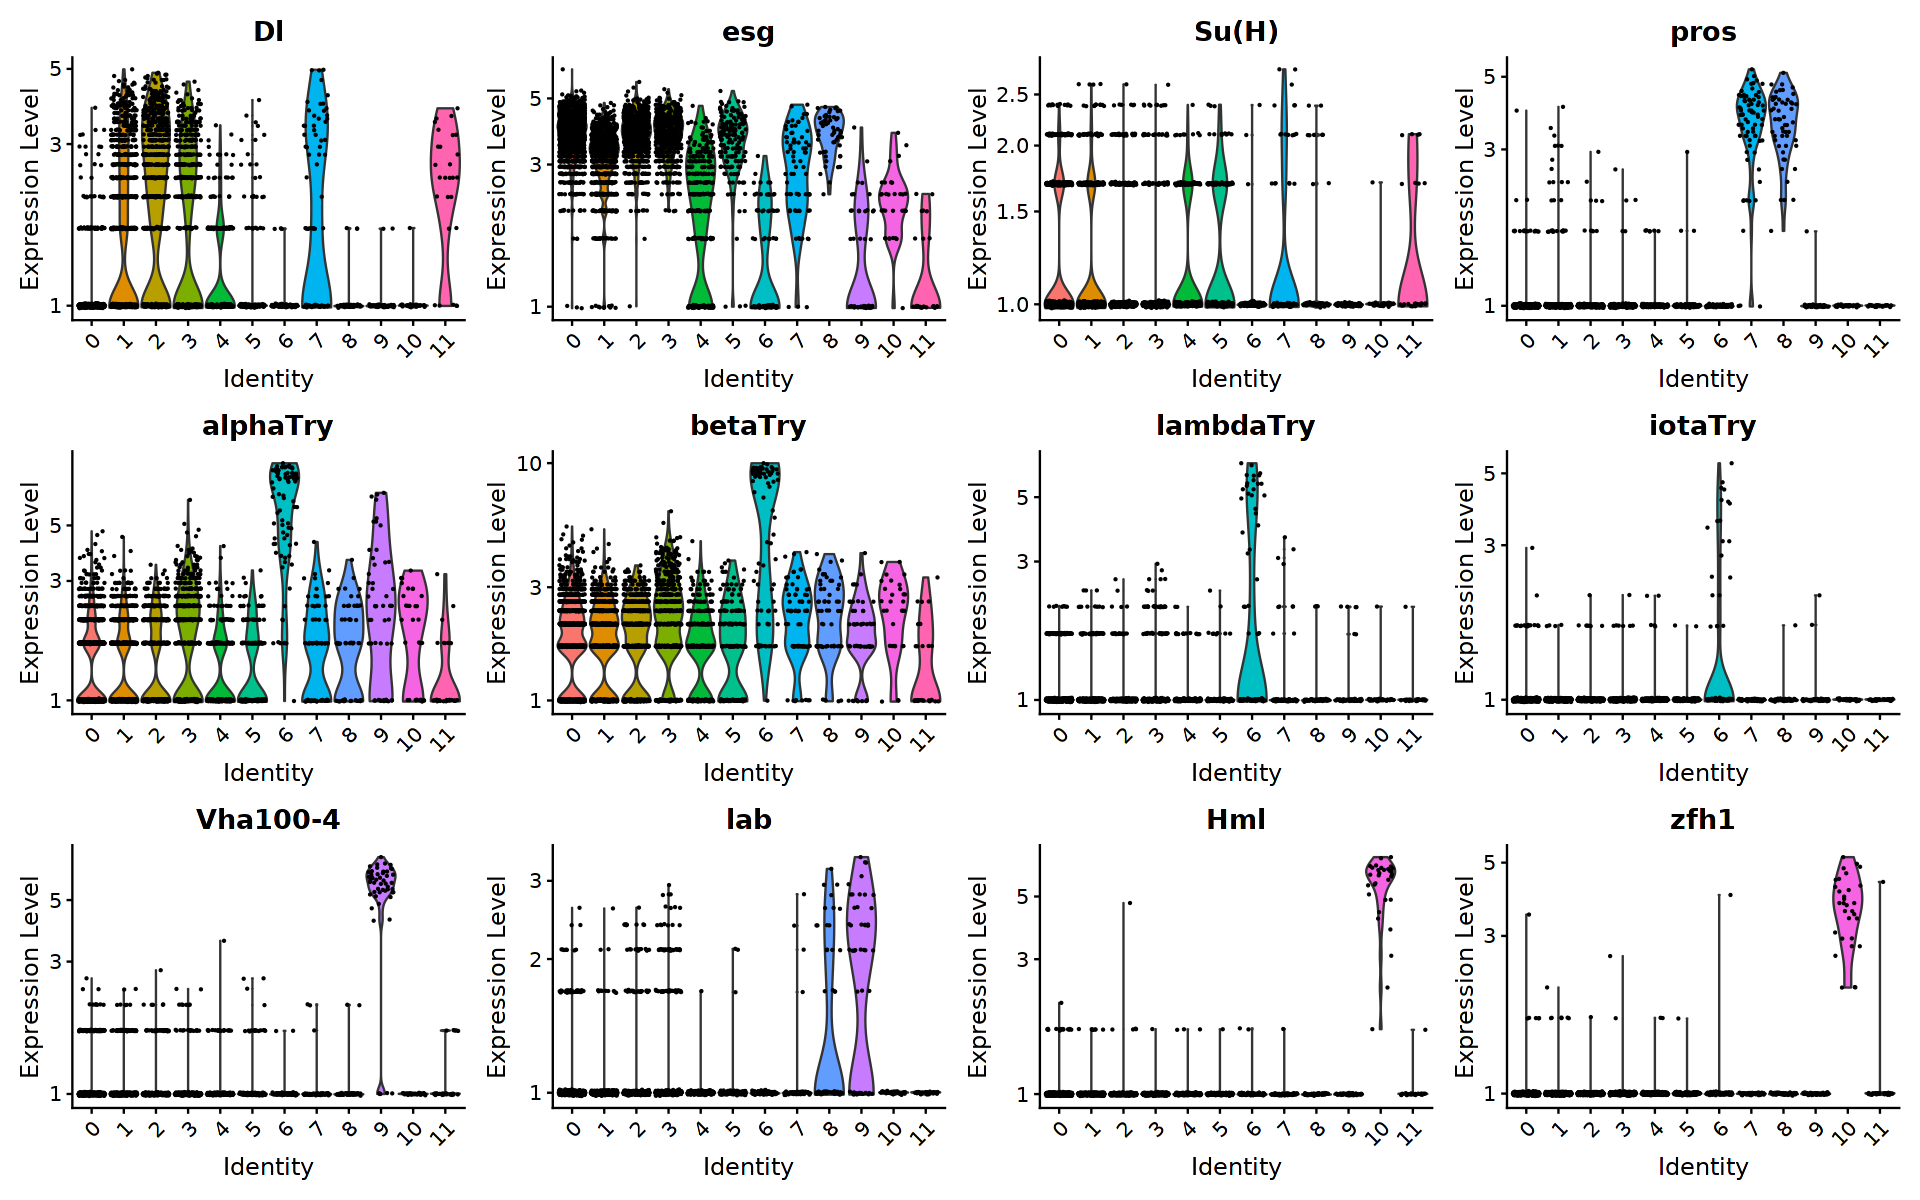

In [36]:
VlnPlot(object = so, features= markergenes, slot = "data", log = TRUE)
ggsave("results/seurat_QC_plots/violin_marker_genes.pdf", width = 16, height = 10)

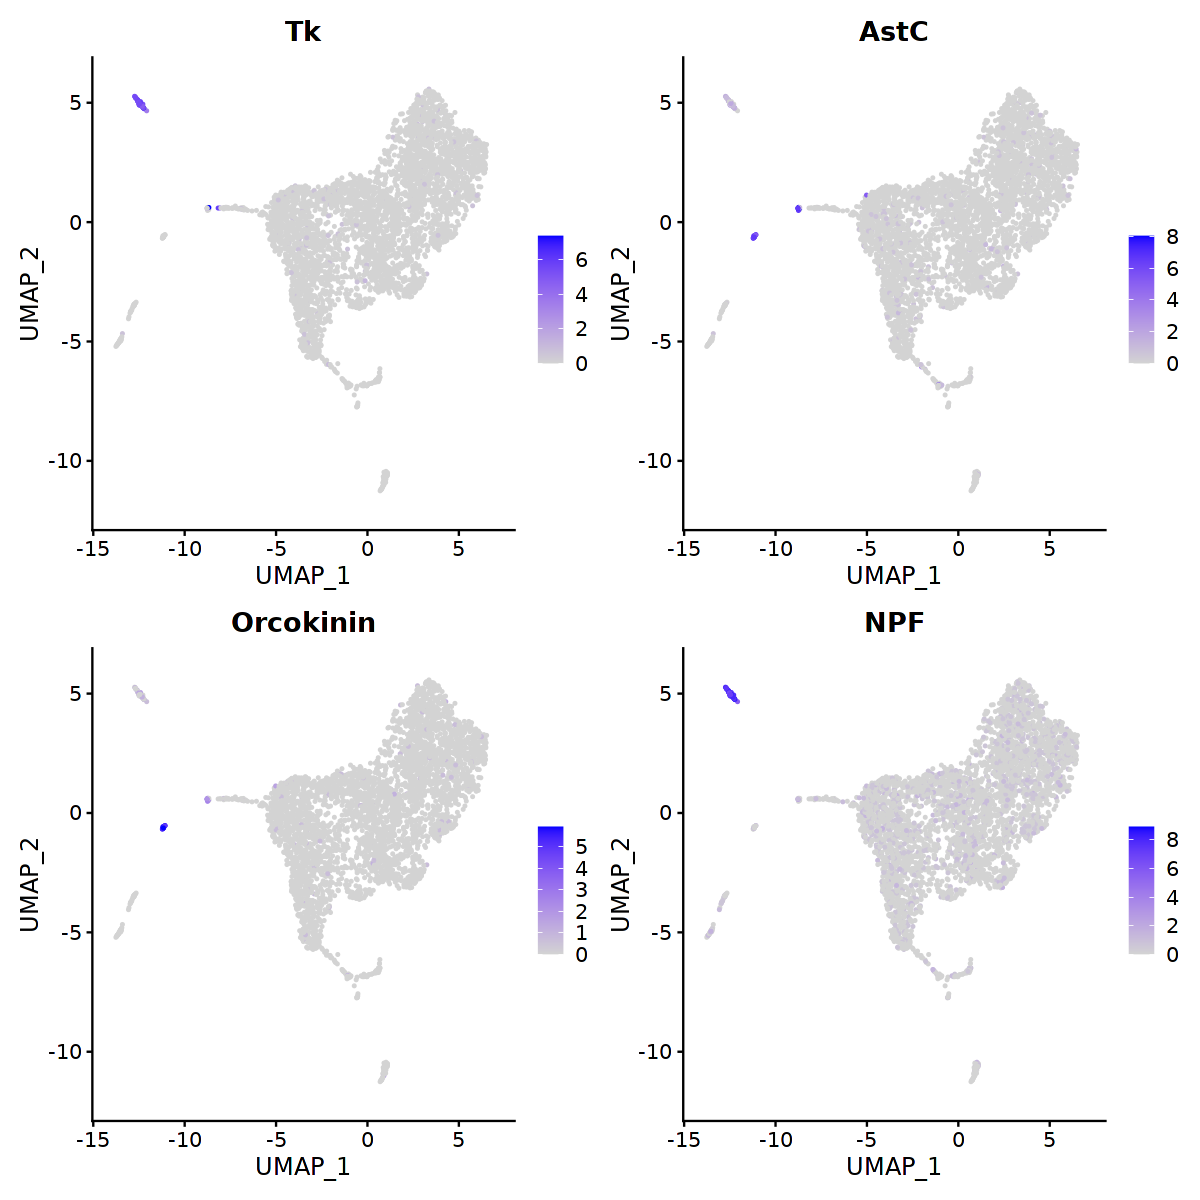

In [37]:
# Marker genes for EE cells
markergenes_EE <- c("Tk", "AstC", "Orcokinin", "NPF")
options(repr.plot.width = 10, repr.plot.height = 10)
FeaturePlot(object = so,
            features = markergenes_EE,
            cols = c("lightgrey", "blue"), 
            reduction= "umap")
ggsave("results/seurat_QC_plots/UMAP_marker_genes_EEcells.pdf", width = 10, height = 10)

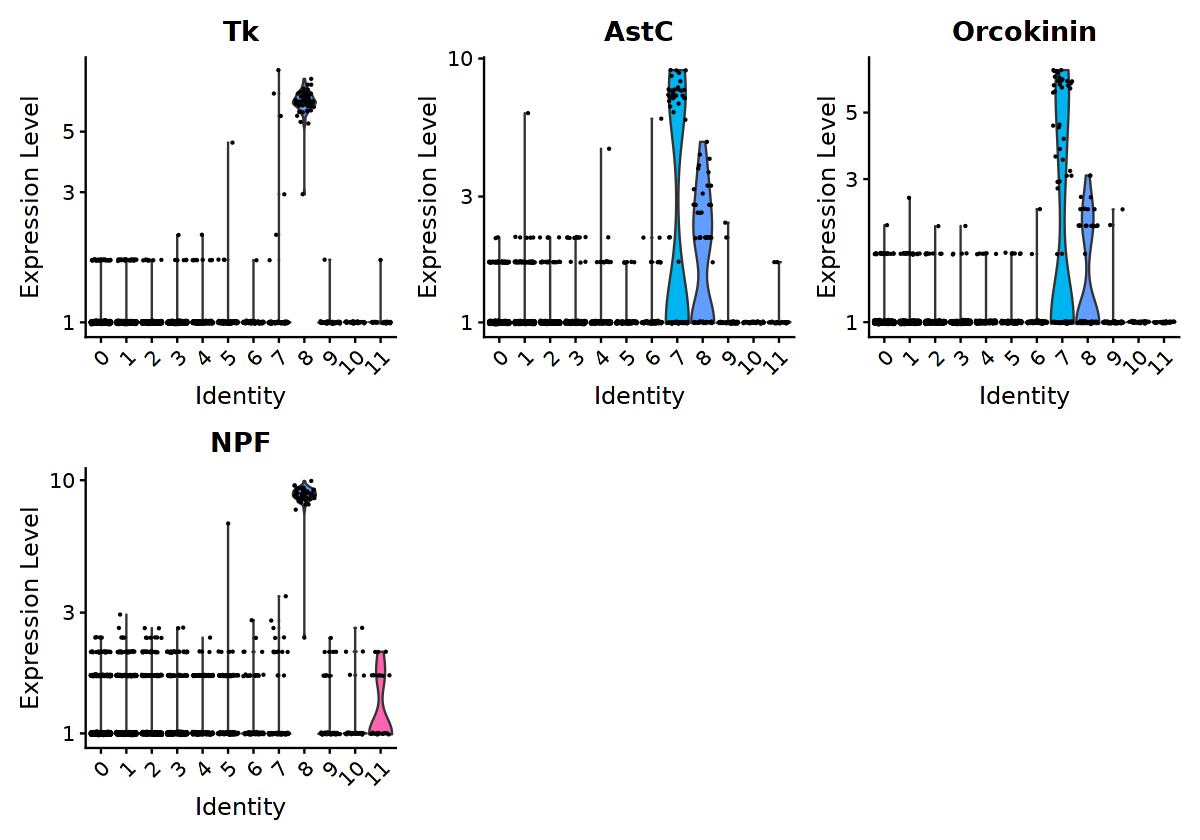

In [38]:
options(repr.plot.width = 10, repr.plot.height = 7)
VlnPlot(object = so, features= markergenes_EE, slot = "data", log = TRUE)
ggsave("results/seurat_QC_plots/violin_marker_genes_EEcells.pdf", width = 10, height = 7)

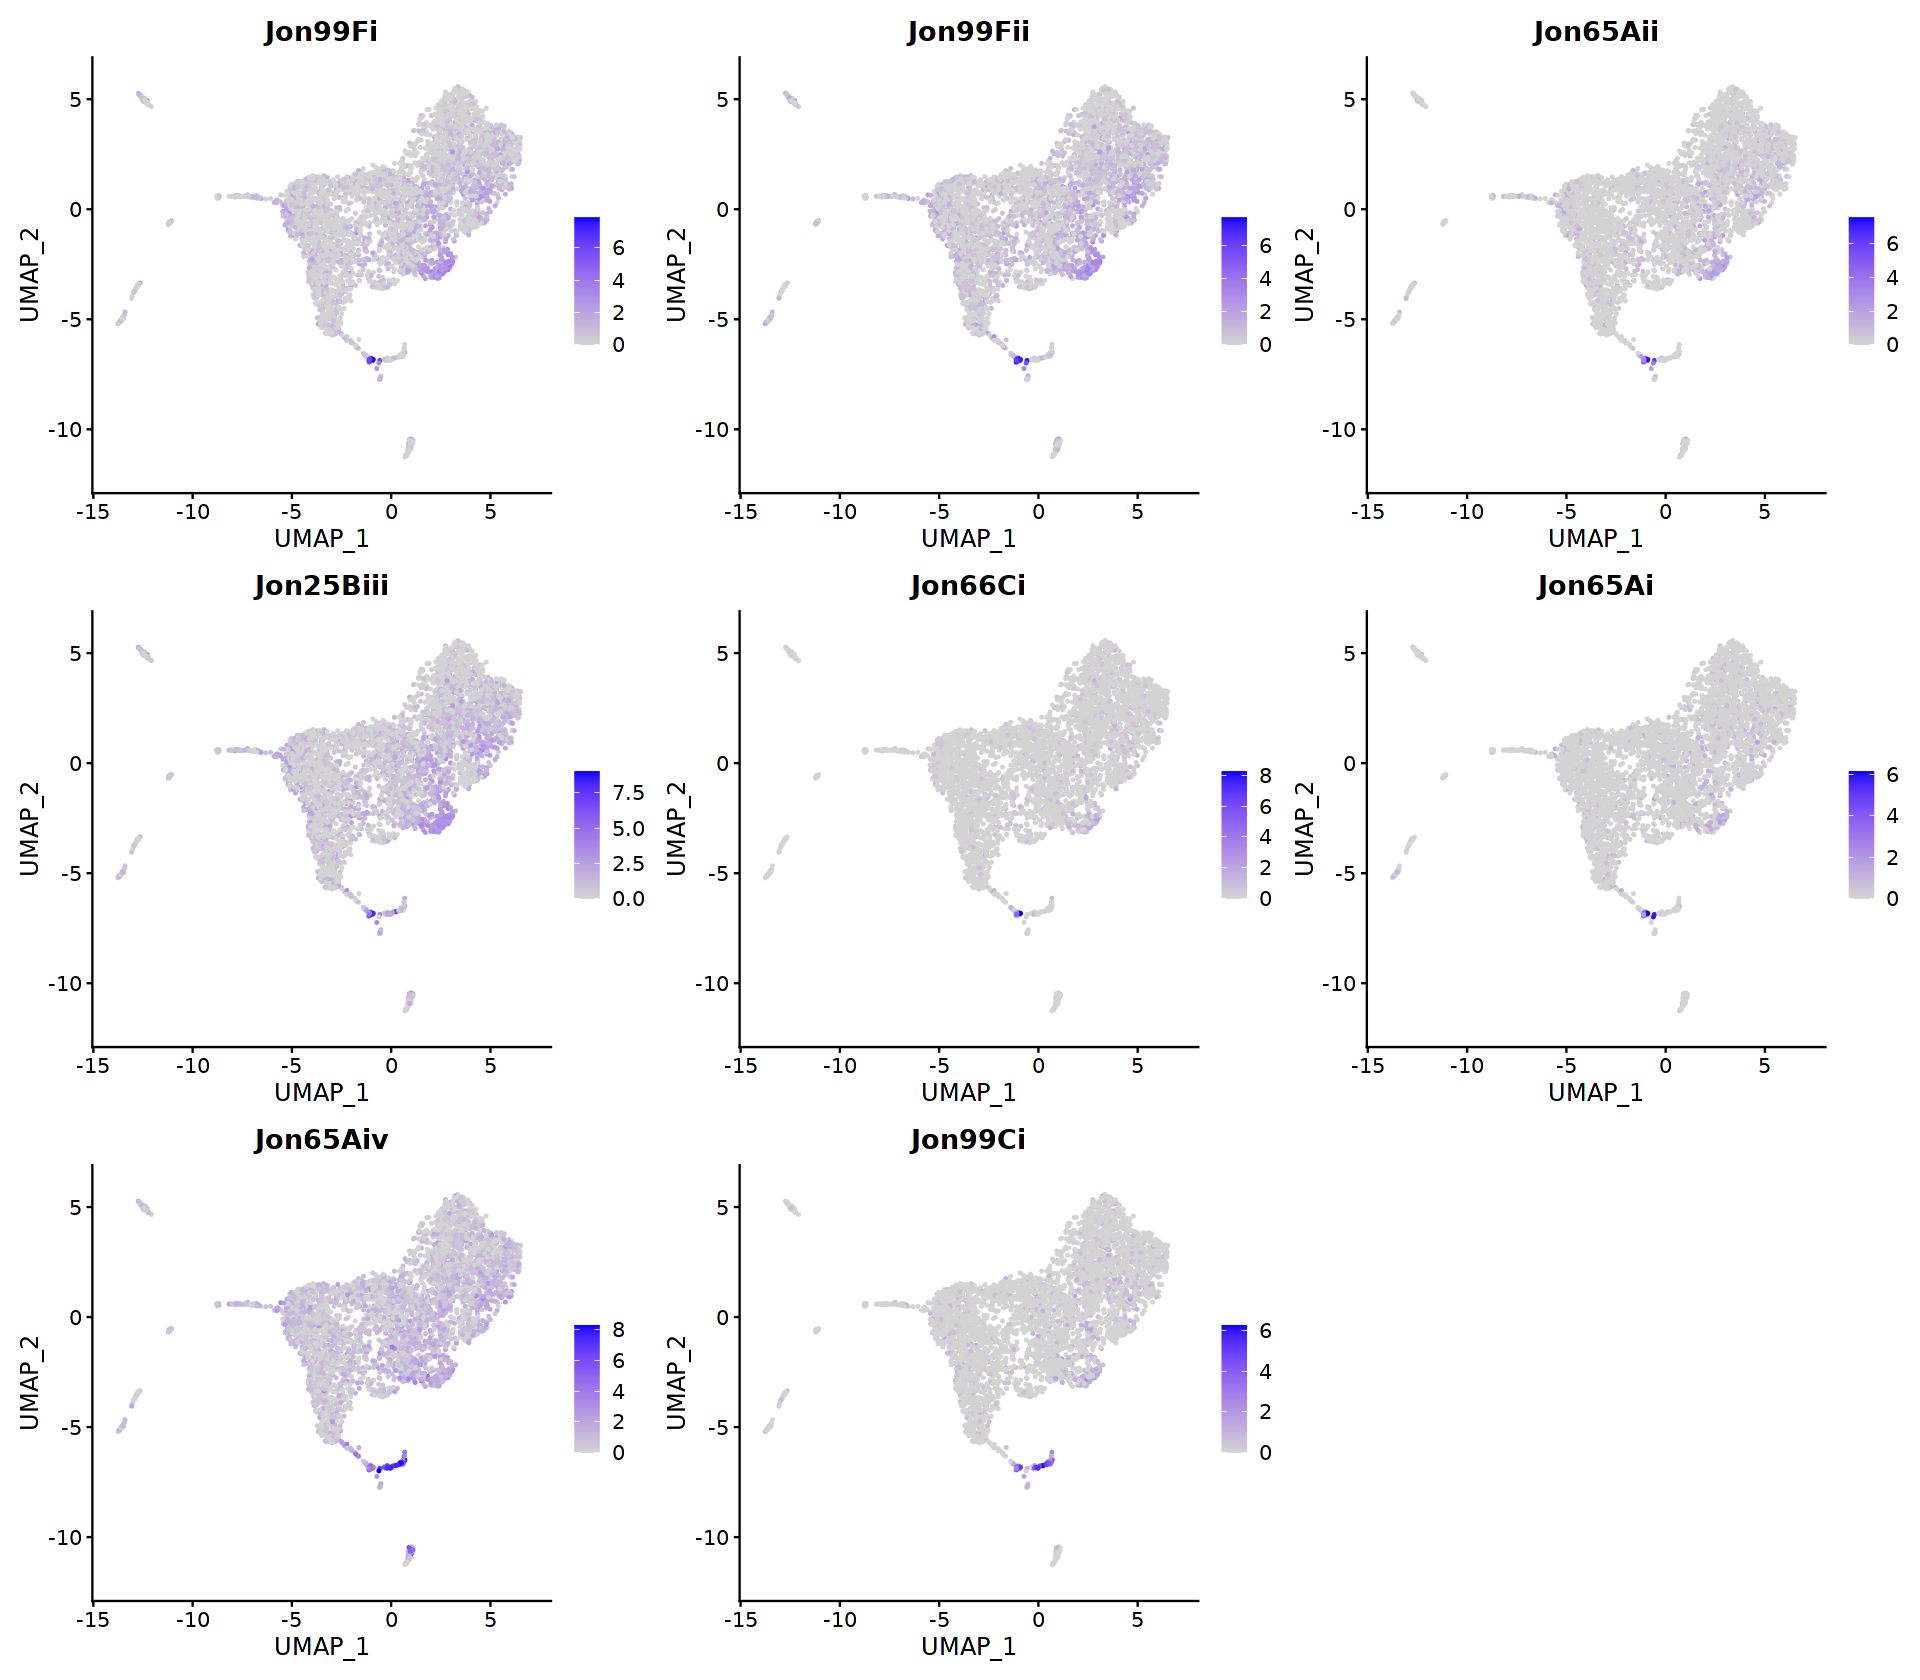

In [39]:
# marker genes for apEC 
markergenes_endopeptidase <- c("Jon99Fi", "Jon99Fii", "Jon65Aii", "Jon25Biii", "Jon66Ci", "Jon65Ai", "Jon65Aiv", "Jon99Ci")
options(repr.plot.width = 16, repr.plot.height = 14)
FeaturePlot(so, features = markergenes_endopeptidase,
    cols = c("lightgrey", "blue"),
    reduction= "umap")
ggsave("results/seurat_QC_plots/UMAP_marker_genes_apEC.pdf", width = 16, height = 14)

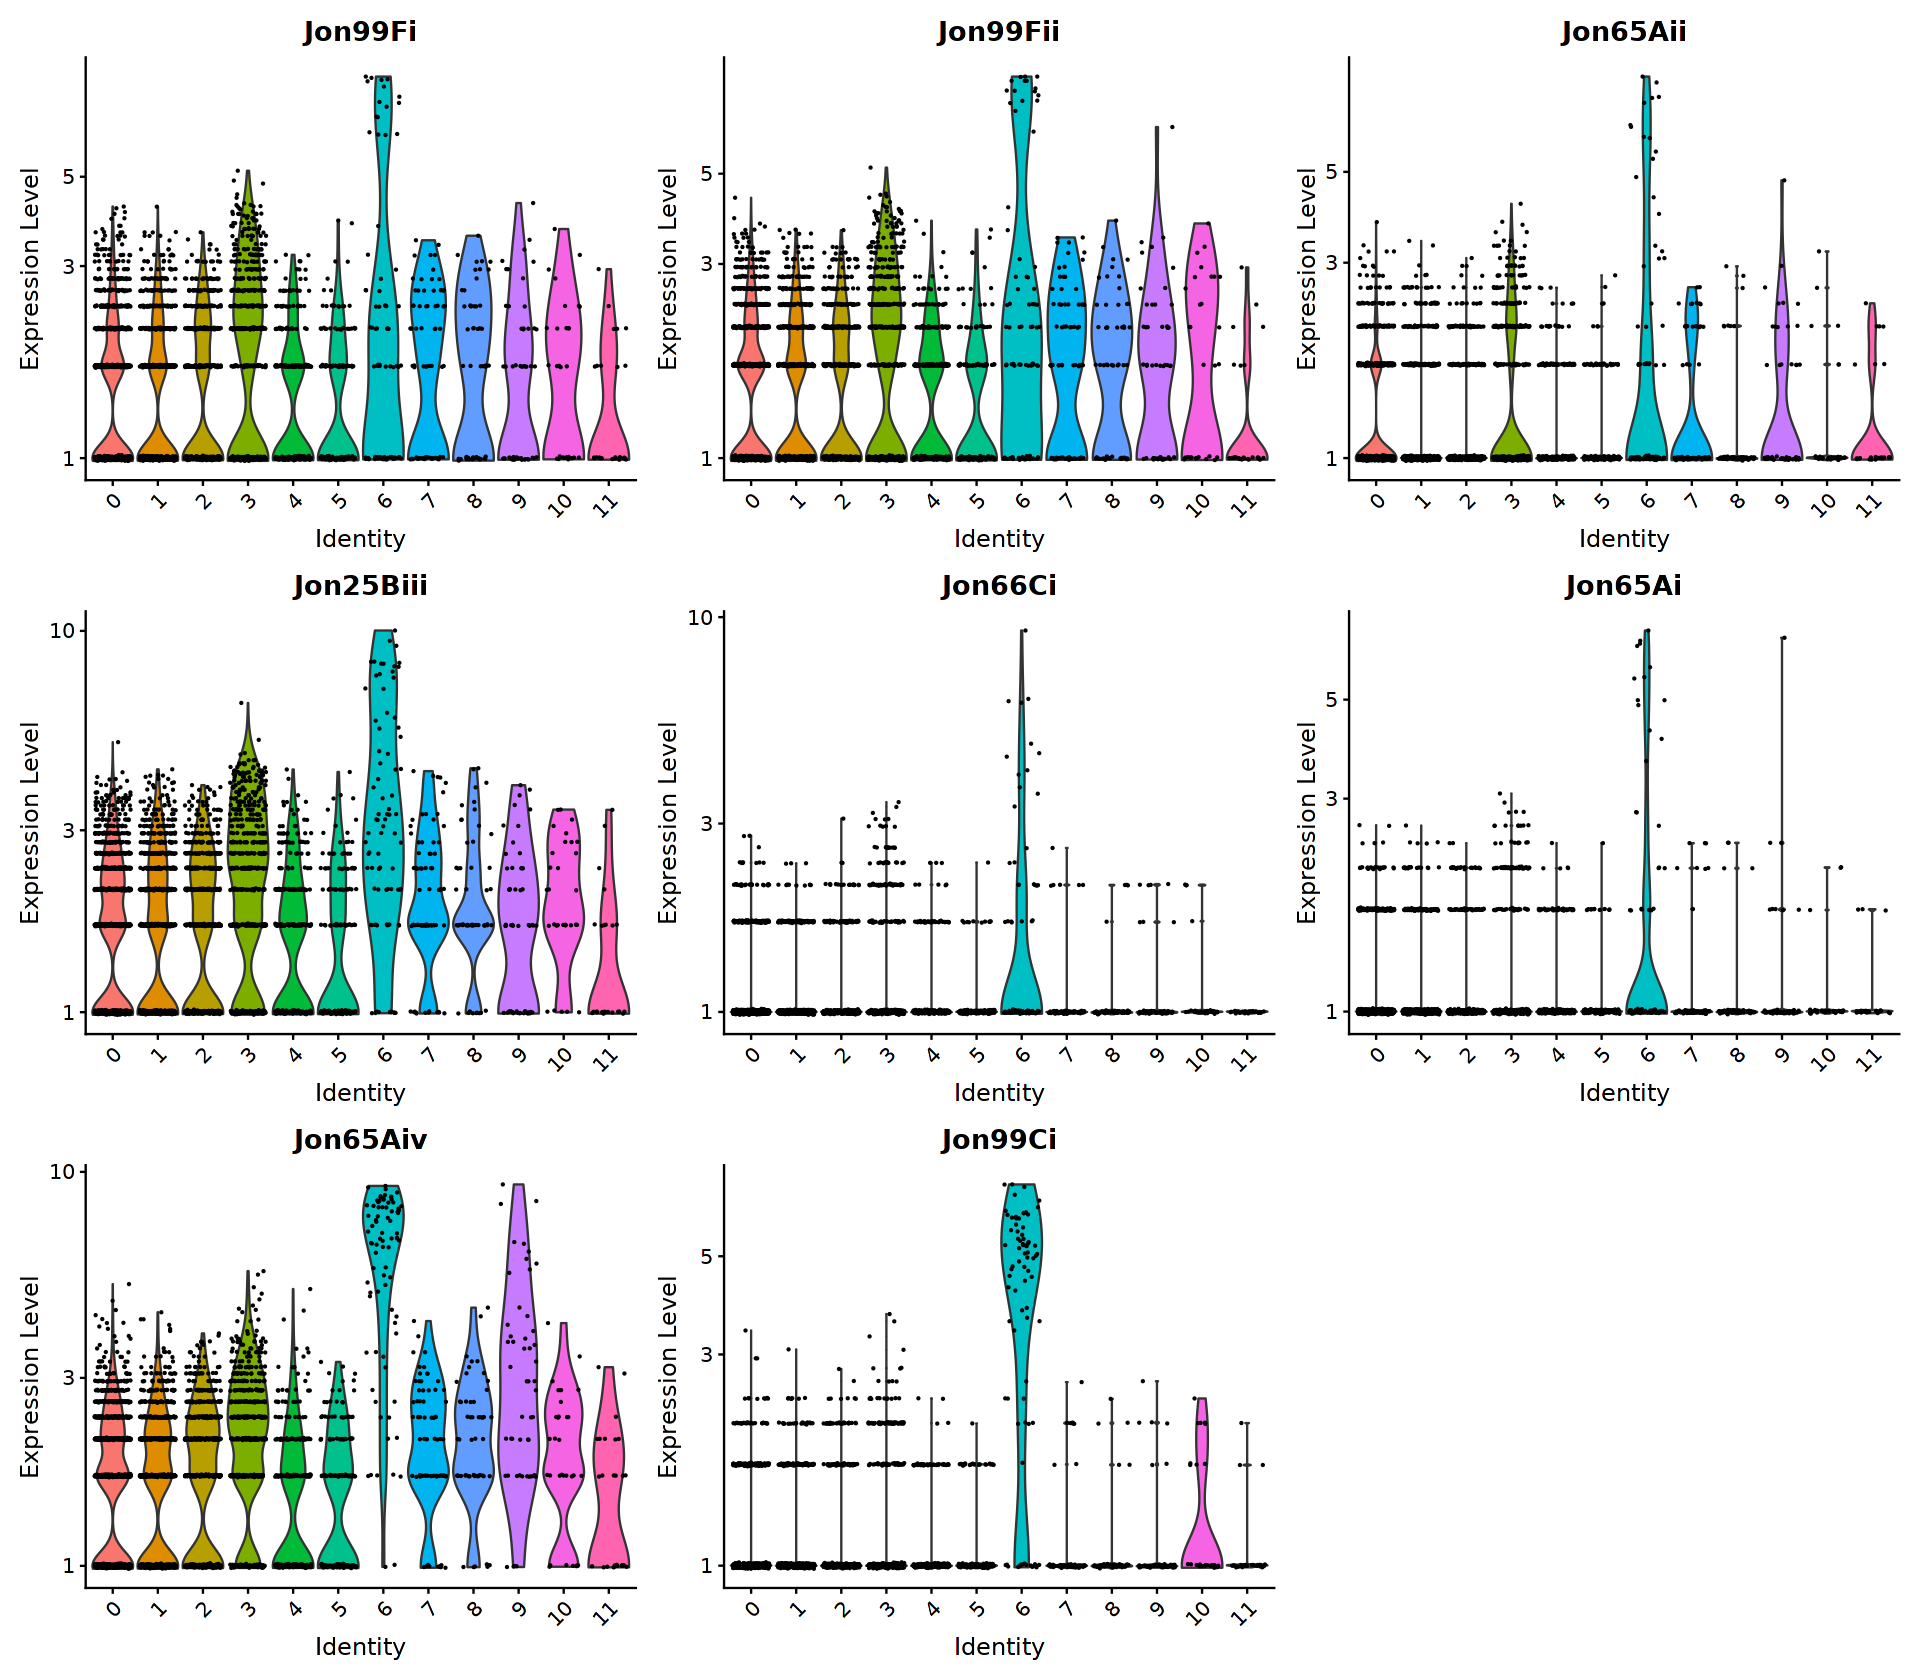

In [40]:
VlnPlot(so, features= markergenes_endopeptidase, slot = "data", log = TRUE)
ggsave("results/seurat_QC_plots/violin_marker_genes_apEC.pdf", width = 16, height = 14)

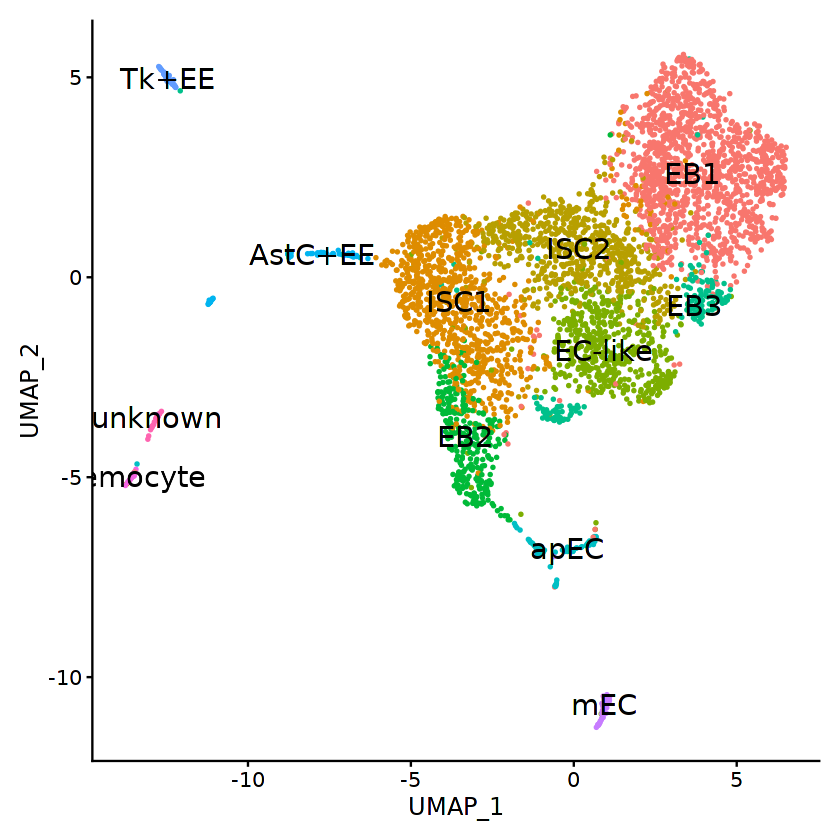

In [41]:
# Rename cells based on the marker genes and feeling
new.cluster.ids <- c("EB1", "ISC1", "ISC2", "EC-like", "EB2", "EB3", "apEC", "AstC+EE", "Tk+EE", "mEC", "Hemocyte", "unknown")
names(new.cluster.ids) <- levels(so)
so <- RenameIdents(so, new.cluster.ids)

options(repr.plot.width = 7, repr.plot.height = 7)
DimPlot(so, reduction = "umap", label = TRUE, pt.size = 0.5, label.size = 6) + NoLegend()
ggsave("results/seurat_QC_plots/UMAP_clusters_labeled.pdf", width = 7, height = 7)

In [42]:
# Save results including all clusters
#saveRDS(so, file = "datasets/seurat/Seurat_aggr_QC1.rds")

In [43]:
# Remove the 'hemocyte' cluster
so <- subset(so, idents = c("Hemocyte"), invert = TRUE)
so

An object of class Seurat 
51640 features across 4245 samples within 4 assays 
Active assay: SCT (9751 features, 3000 variable features)
 3 other assays present: spliced, unspliced, ambiguous
 2 dimensional reductions calculated: pca, umap

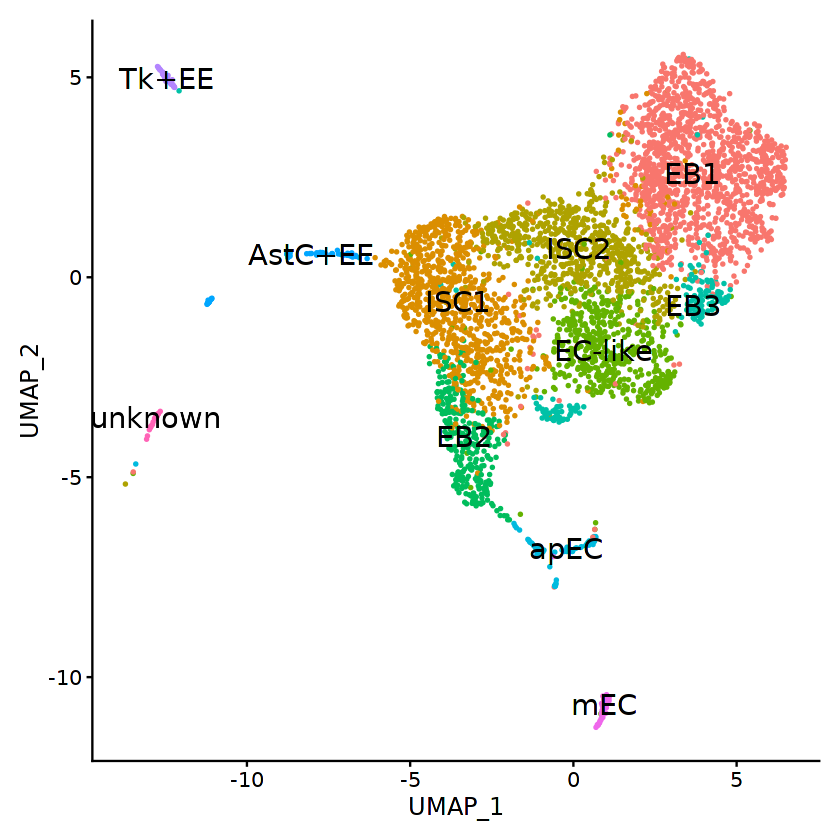

In [44]:
options(repr.plot.width = 7, repr.plot.height = 7)
DimPlot(so, reduction = "umap", label = TRUE, pt.size = 0.5, label.size = 6) + NoLegend()

In [45]:
# Save results after removing the hemocyte cluster of cells
#saveRDS(so, file = "datasets/seurat/Seurat_aggr_QC1.rds")

In [46]:
# Remove the 'unknown' cluster. Nagai-san confirmed that they are not related
so <- subset(so, idents = c("unknown"), invert = TRUE)
so

An object of class Seurat 
51640 features across 4218 samples within 4 assays 
Active assay: SCT (9751 features, 3000 variable features)
 3 other assays present: spliced, unspliced, ambiguous
 2 dimensional reductions calculated: pca, umap

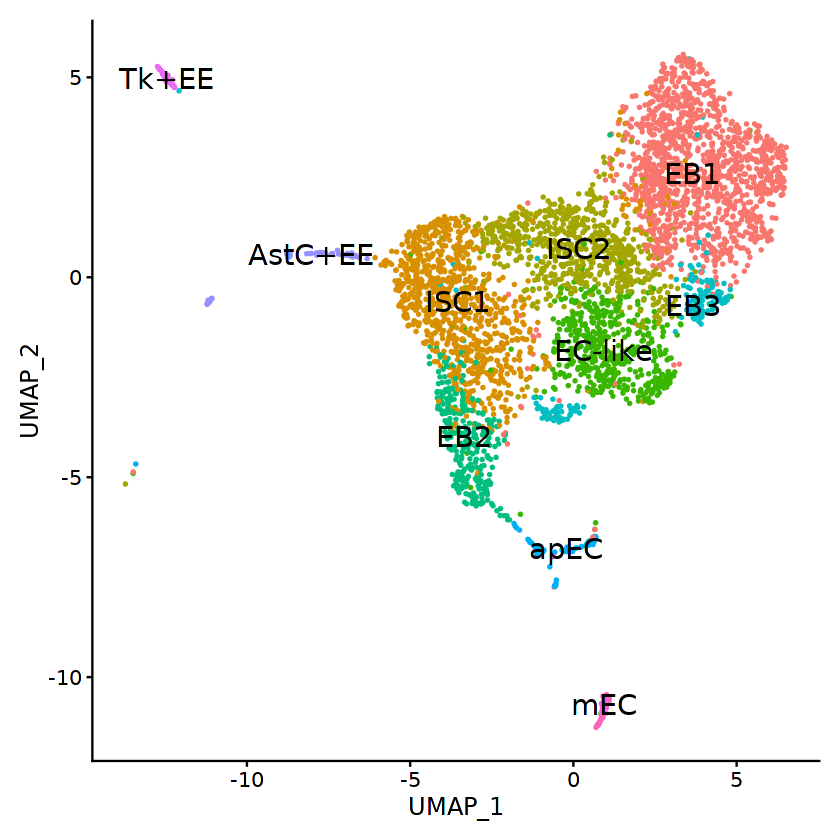

In [47]:
options(repr.plot.width = 7, repr.plot.height = 7)
DimPlot(so, reduction = "umap", label = TRUE, pt.size = 0.5, label.size = 6) + NoLegend()
ggsave("results/seurat_QC_plots/UMAP_clusters_labeled_final.pdf", width = 7, height = 7)

In [54]:
# create output directory and save image there
dir <- file.path("datasets", "seurat") 
if (!dir.exists(dir)) dir.create(dir, recursive = TRUE)

# Save results of QC1
saveRDS(so, file = "datasets/seurat/Seurat_aggr_QC1.rds")

In [60]:
summary(Idents(object= so))

EB1    ISC1    ISC2 EC-like     EB2     EB3    apEC AstC+EE   Tk+EE     mEC 
   1380     907     683     515     307     166      81      74      54      51

In [61]:
round(prop.table(table(Idents(so))), digits=3)


    EB1    ISC1    ISC2 EC-like     EB2     EB3    apEC AstC+EE   Tk+EE     mEC 
  0.327   0.215   0.162   0.122   0.073   0.039   0.019   0.018   0.013   0.012 

In [64]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/atlas/libblas.so.3.10.3
LAPACK: /usr/lib/x86_64-linux-gnu/atlas/liblapack.so.3.10.3

locale:
 [1] LC_CTYPE=ja_JP.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=ja_JP.UTF-8        LC_COLLATE=ja_JP.UTF-8    
 [5] LC_MONETARY=ja_JP.UTF-8    LC_MESSAGES=ja_JP.UTF-8   
 [7] LC_PAPER=ja_JP.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=ja_JP.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] SeuratDisk_0.0.0.9019       magrittr_2.0.1             
 [3] patchwork_1.1.1             monocle3_0.2.3.0           
 [5] velocyto.R_0.6              Matrix_1.3-4               
 [7] MAST_1.16.0                 SingleCellExperiment_1.12.